# Calculation and visualization of the Michel-Lévy color chart  (1/2)

## based on: 

##  "A revised Michel-Lévy interference colour chart based on first-principles calculations"  
### by Sørensen, Bjørn Eske
~~~
European Journal of Mineralogy, 2013, 25. Jg., Nr. 1, S. 5-10
http://eurjmin.geoscienceworld.org/content/25/1/5
~~~

Implementation by the original author can be found here:
https://www.researchgate.net/profile/Bjorn_Sorensen/publications
It's in matlab, so I could not run it.

All credit goes to Mr. Sørensen. I just found his work, implemented it in python and made the chart with matplotlib. The goal was to reproduce the results of the article and make them accessible and usable without a matlab license (and I think the notebook is a better way to publish stuff like this).

# Description

For details see the original article.

## 1. Transmission L

$ L = cos^2\phi - sin^2(\tau-\phi)\;sin^2(\tau)\;sin^2(\frac{180° \Gamma}{\lambda})$

- L : fraction of transmitted light (of a certain wavelength) 
- $\phi$ : angle between vibration directions of the polarizer and analyzer
- $\tau$ : angle between polarizer's privileged direction and the crystal's closest privileged direction
- $\lambda$ : wavelength
- $\Gamma$ : path difference 
    - $\Gamma = \mathrm{thickness} \cdot \mathrm{birefringence} $
    - $\mathrm{birefringence} = (n_{\gamma} - n_{\alpha})$

If the analyzer and polarizer are oriented 90° to each other, this formula is reduced to:

$L(\Gamma,\lambda)=sin^2(\frac{180° \Gamma}{\lambda})$


## 2. Conversion from wavelength to color

In order to visualize the colors on a print or screen, we need to map to real colors.

### 2.1. Colors from wavelength
The CIE colormatching functions ($r(\lambda)$, $g(\lambda)$, $b(\lambda)$) map wavelengths to the color perceived by humans. The functions can be downloaded in tabularized form at http://cvrl.ioo.ucl.ac.uk/index.htm .

- https://en.wikipedia.org/wiki/CIE_1931_color_space
    
The colormatching functions yield X, Y, Z components in the CIE colorspace: 

$\left[\begin{array}{c} r(\lambda) \\g(\lambda)\\b(\lambda) \end{array}\right]  = 
\left[\begin{array}{c} X\\Y\\Z \end{array}\right] $

(Plots of the function are shown later in this notebook)

Because we deal with white light we have to sum up the result for all wavelengths in the visible spectral region. The formula above can be written in matrix form for all $\lambda$ in the visible spectrum and all relevant $\Gamma$:

$L_{XYZ} = \left[\begin{array}{c} r(\lambda_1) & \cdots & r(\lambda_n) \\
                       g(\lambda_1) & \cdots & g(\lambda_n) \\
                       b(\lambda_1) & \cdots & b(\lambda_n)  \end{array}\right] 
                       \left[\begin{array}{c} L(\lambda_1,\Gamma_1) &\cdots& L(\lambda_1,\Gamma_n)\\ 
                       \vdots                &\ddots&  \vdots  \\
                       L(\lambda_n,\Gamma_1) &\cdots& L(\lambda_n,\Gamma_n) \end{array}\right]
                       = \left[\begin{array}{c}
                       \sum\limits_{i=\lambda_1\cdots\lambda_n} r(\lambda_i)\,L(\lambda_i\Gamma_1) 
                       & \cdots & \sum\limits_{i=\lambda_1\cdots\lambda_n} r(\lambda_i)\,L(\lambda_i\Gamma_n) \\
                       \sum\limits_{i=\lambda_1\cdots\lambda_n} g(\lambda_i) \,L(\lambda_i\Gamma_1) 
                       & \cdots & \sum\limits_{i=\lambda_1\cdots\lambda_n} g(\lambda_i) \,L(\lambda_i\Gamma_n) \\
                       \sum\limits_{i=\lambda_1\cdots\lambda_n} b(\lambda_i) \,L(\lambda_i\Gamma_1) 
                       & \cdots & \sum\limits_{i=\lambda_1\cdots\lambda_n} b(\lambda_i) \,L(\lambda_i\Gamma_n) 
                       \end{array}\right] =
                       \left[\begin{array}{ci} 
                       X_{\Gamma_1} & \cdots & X_{\Gamma_n}\\
                       Y_{\Gamma_1} & \cdots & Y_{\Gamma_n}\\
                       Z_{\Gamma_1} & \cdots & Z_{\Gamma_n}
                       \end{array}\right] $


### 2.2. Transfrom XYZ to Adobe RGB or SRGB


$RGB_{linear} =  \left[\begin{array}{c} R\\G\\B \end{array}\right]
= MRGB\left[\begin{array}{c} X\\Y\\Z \end{array}\right] $ 

- Adobe RGB (from original article):

$MRGB =  \left[\begin{array}{c} 2.04414 & -0.5649 & -0.3447\\ 
-0.9693 & 1.8760 & 0.0416\\
0.0134 & -0.1184 & 1.0154  \end{array}\right] $

- SRGB (from Wikipedia):

$MRGB = \left[\begin{array}{c} 3.2406 & -1.5372 & -0.4986 \\
                              -0.9689 & 1.8758 & 0.0415 \\
                               0.0557 & -0.2040 & 1.0570 \end{array}\right] $

- https://en.wikipedia.org/wiki/Adobe_RGB_color_space
- https://en.wikipedia.org/wiki/SRGB_color_space

### 2.3. Clipping and Gamma correction
- In the original article values > 100 or < 0 are replaced with 100 and 0 respectively.
- Apply gamma-correction to represent real colors more accurately.

   

# Code

In [6]:
""" Imports """

import numpy as np
import matplotlib.pyplot as plt

In [7]:
""" figure parameters """

min_thickness = 0*1E3 
max_thickness = 50*1E3
thickn_step = 1
thicknesses = np.arange(min_thickness, max_thickness, thickn_step)

min_birefringence = 0.0
max_birefringence = 0.05   
birefstep = 0.00002
birefringences = np.arange(min_birefringence, max_birefringence, birefstep)

min_wavelength = 360
max_wavelength = 830
wlstep = 1
wavelengths = np.arange(min_wavelength, max_wavelength, wlstep)

In [8]:
""" read CIE data and interpolate for given wavelengths  """

def read_csv(filename):
    with open(filename, "r") as f:
        content = f.read()
    data = []
    for line in content.splitlines():
        row = []
        for element in line.split(","):
            if element == "":
                element = 0
            row.append(float(element))
        data.append(row)
    return np.array(data)
        
filename = "ciexyz31_1.csv"
csvdata = read_csv(filename)

xdata = csvdata.T[0,:]
XYZ = (csvdata.T[1:])

XYZ_interpol = np.ones([3,len(wavelengths)])

for i,ydata in enumerate(XYZ):
    XYZ_interpol[i, :] = np.interp(wavelengths, xdata, ydata)

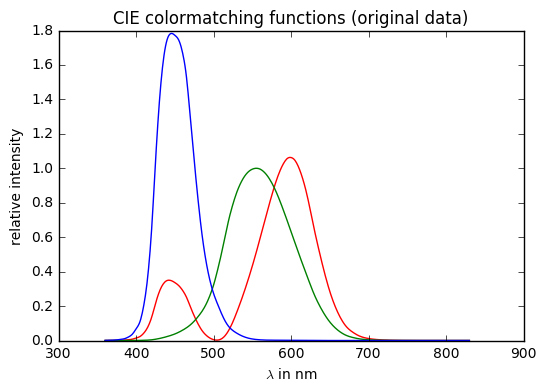

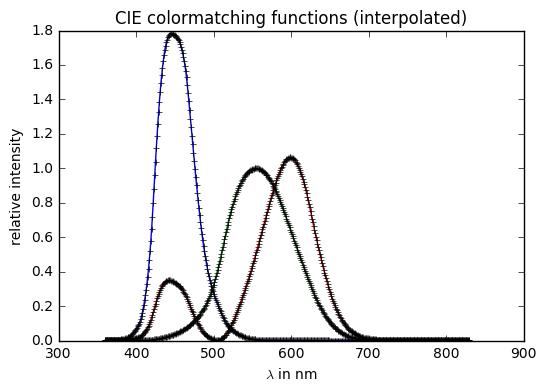

In [9]:
"""  plot the CIE-data and check interpolation """
fig,ax = plt.subplots(1)

ax.set_title("CIE colormatching functions (original data)")
ax.plot(xdata,XYZ[0], color="red")
ax.plot(xdata,XYZ[1], color="green")
ax.plot(xdata,XYZ[2], color="blue")
ax.set_xlabel(r"$\lambda$ in nm")
ax.set_ylabel(r"relative intensity")

fig,ax = plt.subplots(1)
ax.set_title("CIE colormatching functions (interpolated)")
ax.plot(xdata,XYZ[0], color="red")
ax.plot(xdata,XYZ[1], color="green")
ax.plot(xdata,XYZ[2], color="blue")
ax.plot(wavelengths, XYZ_interpol[0], color="black", ls="", marker="+", 
        markersize=5)
ax.plot(wavelengths, XYZ_interpol[1], color="black", ls="", marker="+", 
        markersize=5)
ax.plot(wavelengths, XYZ_interpol[2], color="black", ls="", marker="+", 
        markersize=5)
ax.set_xlabel(r"$\lambda$ in nm")
ax.set_ylabel(r"relative intensity")

plt.show()

In [10]:
""" calculate Transmission L """

L = np.zeros([len(wavelengths),len(birefringences)])

# calculate for one thickness and all birefringences
Gamma = max_thickness * birefringences  #<--- warum max. thickness?

for i,wl in enumerate(wavelengths):
    val = (Gamma/wl)*180
    val = np.sin(val*np.pi/180)
    val = val**2
    L[i,:] = val
    
""" calculate L_XYZ """
L_XYZ = np.dot(XYZ_interpol, L)

""" convert to RGB (comment out SRGB to use Adobe RGB)"""
# Adobe RGB
XYZ_to_RGB = np.array([[2.04414, -0.5649, -0.3447],
                        [-0.9693, 1.8760, 0.0416],
                        [0.0134, -0.1184, 1.0154]])

# SRGB
XYZ_to_RGB = np.array([[3.2406, -1.5372, -0.4986],
                        [-0.9689, 1.8758, 0.0415],
                        [0.0557, -0.2040, 1.0570]])

RGB = np.dot(XYZ_to_RGB, L_XYZ)

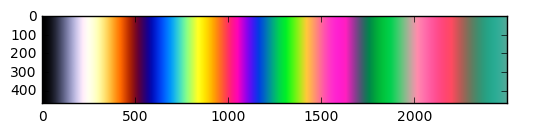

In [11]:
""" clipping and normalizing; firt look at the results """

# clipping
RGB[RGB>100] = 100
RGB[RGB<0] = 0

# normalize to 1
RGB/=100

# prepare plot (stack RGB-vs Gamma arrays)
RGB_plot = np.zeros([len(wavelengths),len(birefringences),3])
RGB_plot[:,:,0] = RGB[0,:]
RGB_plot[:,:,1] = RGB[1,:]
RGB_plot[:,:,2] = RGB[2,:]

XYZ_to_RGB = np
plt.close("all")
fig,ax = plt.subplots(1)

ax.imshow(RGB_plot, origin="upper")

plt.show()

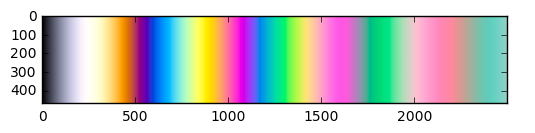

In [12]:
""" simple gamma correction """

gamma_factor = 1/2.0     # <-- change for your screen
RGB_plot_gamma = RGB_plot**gamma_factor

plt.close("all")
fig,ax = plt.subplots(1)
ax.imshow(RGB_plot_gamma, origin="upper")
plt.show()

## Sanity check
This looks good. Let's compare the results to the chart from Zeiss.

In [13]:
# --- import reference chart
from scipy import misc
ref_img = misc.imread("./chart_reference.png")

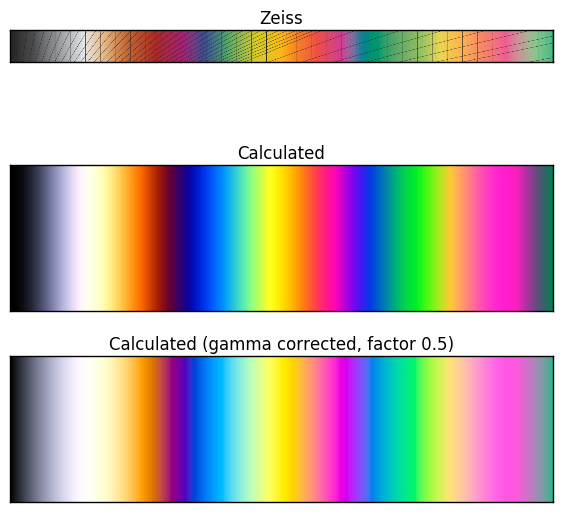

In [14]:
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.imshow(ref_img)
ax1.set_xticks([])
ax2.set_xticks([])
ax2.imshow(RGB_plot[:,:1751,:])       #<--- reference image doesn't cover the whole range
ax3.imshow(RGB_plot_gamma[:,:1751,:]) #<--- reference image doesn't cover the whole range

for ax in [ax1, ax2, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])

ax1.set_title("Zeiss")
ax2.set_title("Calculated")
ax3.set_title("Calculated (gamma corrected, factor {:.1f})".format(gamma_factor))

plt.show()


The most obvious differences are:

- Less pronounced grey first order.
- Missing green second order after gamma correction. This was also observed in the original article (Look there for detailed discussion and references). 
- Less pronounced reds and oranges (esp. after the gamma correction).
- The blues are too strong before the correction.

TODO: The gamma-correction might need tweaking. 

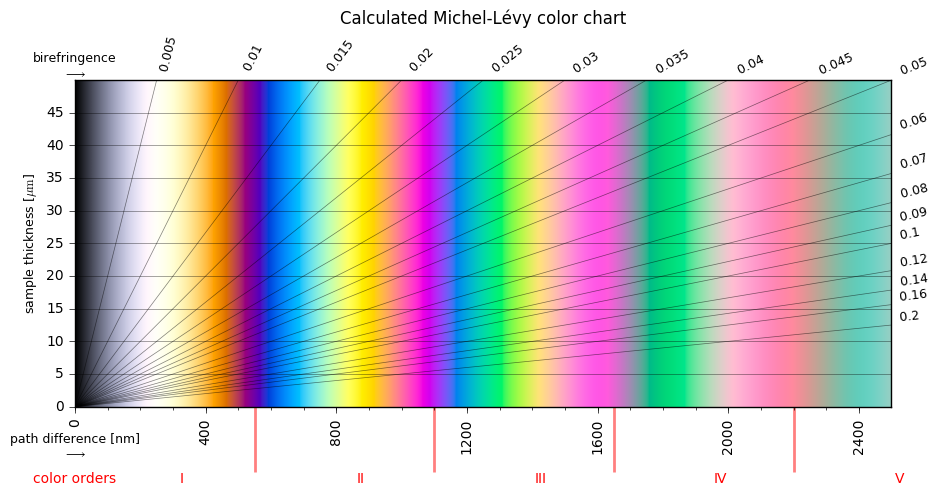

In [16]:
""" finishing the diagram """

#--- define what data to plot
RGB_plot_final = RGB_plot_gamma

#--- setup
plt.close("all")
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
textprops = {"zorder":200, "size":9}
aspect = 20

#--- define axis limits
xlims = [min(Gamma), max(Gamma)]
ylims = [min(thicknesses)*1E-3, max(thicknesses)*1E-3]

#--- plot image
ax.imshow(RGB_plot_final, origin="upper", 
          extent=xlims+ylims,
          zorder=1, aspect=aspect)

#--- adding lines of constant birefringence (and labels)
biref_label = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03,
              0.035, 0.04, 0.045, 0.05, 0.06, 0.07,
              0.08, 0.09, 0.1, 0.12, 0.14, 0.16, 0.2]
minx = np.min(birefringences)
maxx = np.max(birefringences)
miny = np.min(thicknesses)

xscaler = (xlims[1]-xlims[0])/(max(birefringences)-min(birefringences))
for i,bl in enumerate(biref_label):
    xval = bl*xscaler
    ax.plot((xlims[0], xval), ylims, zorder=100, color="black",lw=0.5, alpha=0.5)
    
    #--- add text
    textrot = 180/np.pi*np.arctan(aspect*(ylims[1]-ylims[0])/(xval-xlims[0]))
    if xval <= xlims[1]:
        ax.text(xval, ylims[1], "  "+str(bl), ha="left", va="bottom", rotation=textrot, **textprops)
    else:
        ytext = ylims[0] + ( (xlims[1]-xlims[0])*((ylims[1]-ylims[0])/(xscaler*bl)) )
        ax.text(xlims[1], ytext, "  "+str(bl), ha="left", va="bottom", rotation=textrot, **textprops)

#--- adding lines and text for color orders
orders = np.arange(550, xlims[1]+550, 550)
orders_letters = ["I", "II", "III", "IV", "V", "VI", "VII"]

for order, letter in zip(orders, orders_letters):
    if order <= xlims[1]:
        ax.vlines(order, ylims[0], ylims[0]-10, clip_on=False, alpha=0.5, zorder=0, color="red", lw=2)
    ax.text(order-225, -10, letter, color="red", ha="center", va="top")

    
#--- finalize plot (limits, ticks, grid-lines) 
ax.set_xlim(*xlims)
ax.set_ylim(*ylims)

yticks =  np.arange(ylims[0], ylims[1], 5)
xticks =  np.arange(xlims[0], xlims[1], 400)
ax.set_xticklabels(["{:.0f}".format(_) for _ in xticks], rotation=90)

for y in yticks:
    ax.axhline(y, zorder=100, color="black",lw=0.5, alpha=0.5)
    
ax.set_yticks(yticks)
ax.set_xticks(xticks)
xminorticks =  np.arange(xlims[0], xlims[1], 100)
ax.set_xticks(xminorticks, minor=True)

ax.tick_params(axis="both", which="both",direction="out", top="off", right="off")

#--- finalize plot (labels, title)
ax.text(xlims[0], ylims[1], "birefringence\n"+r"$\longrightarrow$", ha="center", va="bottom", **textprops)
ax.text(xlims[0], ylims[0]-4, r"path difference [nm]"+"\n"r"$\longrightarrow$", ha="center", va="top", **textprops)
ax.text(xlims[0], ylims[0]-10, r"color orders", ha="center", va="top", color="red")
ax.set_ylabel(r"sample thickness [$\mathrm{\mu m}$]", **textprops)
plt.title("Calculated Michel-Lévy color chart", y=1.15)

#--- show and/or save
#plt.savefig("./calculated_chart.pdf")  # <--- uncomment to save 
#plt.savefig("./calculated_chart.png")  # <--- uncomment to save 
plt.tight_layout()
plt.show()

### For some other applications and a condensed version of the code see part 2 of this notebook.

### TODO

- experiment with other colormatching functions
- better gamma-correction